In [1]:
# Importing libraries
import numpy as np 
import pandas as pd
import tensorflow as tf


In [2]:
df = pd.read_csv('spam.csv',encoding='latin-1')

In [3]:

print("Number of rows : {}".format(df.shape[0]))
print("Number of columns : {}".format(df.shape[1]))
print()

print("Basics statistics: ")
data_desc = df.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

Number of rows : 5572
Number of columns : 5

Basics statistics: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2



Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [4]:
# Trop de valeur manquante dans les unamed

In [5]:

df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Mettre en binaire la colonne V1
df['v1'] = df['v1'].apply(lambda x: 0 if x == 'ham' else 1)
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
!python -m spacy download en_core_web_md -q


2023-06-11 21:56:49.038291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 12.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [8]:
import en_core_web_md
nlp = en_core_web_md.load()

In [9]:
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

In [10]:
df["not_spam"] = df["v2"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
df["not_spam"] = df["not_spam"].apply(lambda x: x.replace("[!\"#$%&()*+,-./:;<=>?@[\\\]^_`{|}~]+"," ").lower().strip())
df["not_spam"] = df["not_spam"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
df.head()

,v1,v2,not_spam
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live


In [11]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer.fit_on_texts(df.not_spam)
df["tokenized_doc"] = tokenizer.texts_to_sequences(df.not_spam)

In [12]:
df.head()

,v1,v2,not_spam,tokenized_doc
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[1, 232, 447, 463, 940, 32, 50, 206, 941, 78, ..."
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[8, 195, 464, 290, 2, 1]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[10, 303, 3, 529, 658, 30, 1, 843, 424, 1, 1, ..."
3,0,U dun say so early hor... U c already then say...,u dun early hor u c,"[2, 125, 149, 1, 2, 79]"
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[703, 20, 659, 130]"


In [13]:
import tensorflow as tf 
import pathlib 
import pandas as pd 
import os
import io
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPool1D, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy

from IPython.display import Image



In [14]:
# Transformer les séquences de la colonne not_spam en une matrice de séquences de même longueur 
# en ajoutant du rembourrage à la fin des séquences plus courtes. 
reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(df.tokenized_doc, padding="post")


In [15]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(reviews_pad,df.v1, test_size=0.2)

In [16]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [17]:
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [18]:
###
 # Let's take a look at a batch of text data. 
for msg, msg_type in train_batch.take(1):
  print(msg, msg_type)
###

tf.Tensor(
[[  1   1   2 ...   0   0   0]
 [ 14 176   0 ...   0   0   0]
 [239 605  90 ...   0   0   0]
 ...
 [  1 222 364 ...   0   0   0]
 [875   1  37 ...   0   0   0]
 [174  43 662 ...   0   0   0]], shape=(64, 74), dtype=int32) tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0], shape=(64,), dtype=int64)


In [40]:

vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[msg.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")
])
     

     

In [41]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 8)             8008      
                                                                 
 global_average_pooling1d_2   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 16)                144       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,169
Trainable params: 8,169
Non-trainable params: 0
_________________________________________________________________


In [42]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[BinaryAccuracy
              ()])
     


In [43]:
history = model.fit(train_batch, 
                    epochs=50, 
                    validation_data=val_batch)

Epoch 1/50
70/70 [==============================] - 1s 5ms/step - loss: 0.6440 - binary_accuracy: 0.8640 - val_loss: 0.5906 - val_binary_accuracy: 0.8735
Epoch 2/50
70/70 [==============================] - 0s 3ms/step - loss: 0.5353 - binary_accuracy: 0.8640 - val_loss: 0.4672 - val_binary_accuracy: 0.8735
Epoch 3/50
70/70 [==============================] - 0s 3ms/step - loss: 0.4272 - binary_accuracy: 0.8640 - val_loss: 0.3787 - val_binary_accuracy: 0.8735
Epoch 4/50
70/70 [==============================] - 0s 3ms/step - loss: 0.3743 - binary_accuracy: 0.8640 - val_loss: 0.3491 - val_binary_accuracy: 0.8735
Epoch 5/50
70/70 [==============================] - 0s 3ms/step - loss: 0.3578 - binary_accuracy: 0.8640 - val_loss: 0.3375 - val_binary_accuracy: 0.8735
Epoch 6/50
70/70 [==============================] - 0s 2ms/step - loss: 0.3484 - binary_accuracy: 0.8640 - val_loss: 0.3291 - val_binary_accuracy: 0.8735
Epoch 7/50
70/70 [==============================] - 0s 3ms/step - loss: 0.33

In [44]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go


In [45]:
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

# Visualization of the training process on the loss function
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                          color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title="Training and validation on the loss function",
    xaxis_title="epochs",
    yaxis_title="Cross Entropy"    
)
fig.show()

In [46]:
from tensorflow.keras.metrics import BinaryAccuracy


In [47]:
# Visualization of accuracy training 
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["binary_accuracy"],
                          name="Training accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history.history["val_binary_accuracy"],
                          name="Validation accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title="Training and Validation Accuracy",
    xaxis_title="epochs",
    yaxis_title="Accuracy"    
)
fig.show()

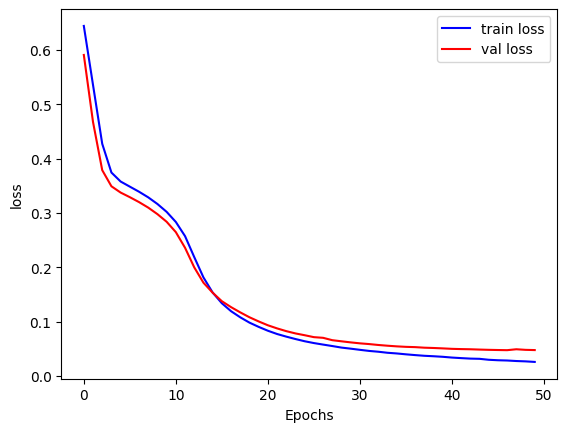

In [48]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b", label="train loss")
plt.plot(history.history["val_loss"], color="r", label="val loss")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()